# Route Option

#### Motivation:
This module focuses on leveraging human knowledge to get the best route. At a  given time due to certain circumstances (like rush hour) it is possible that a certain route may be faster than a route shown on the map. People who travel at those times or people who are residents of those areas have more knowledge about which route should be taken at what time. If every person entered which path to be taken based on their experience we could create a database that will help us to predict which path should be taken.

#### Dataset:
The format of the dataset is as follows:

- uid: the unique id of the the person making the entry.
- rating: the rating of the person adds weightage to the validity of the claim (this follows a rating system similar to that of cab companies) and it ranges from 0-5.
- metro: 0 indicates the area is a metro and 1 indicates it isn't a metro city.
- country: determines in which country the route is. Currently there are 3 countries *Germany*, *England* and *Russia*. 
- startTime: the begining of the time frame when the particular route should be used.
- endTime: the ending of the time frame when the particular route should be used.
- oldRoute: the old route given by the map.
- newRoute: the new route that should be taken.
- mapUsed: 1 indicates that the map is used whereas 0 indicates that the map is not used



Importing all the required packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske
import tensorflow as tf
from tensorflow.contrib import learn as skflow

C:\Users\Saumya Suvarna\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
route_df = pd.read_excel('route.xls', index_col=None, na_values=['NA'])

Let's look at the data

In [3]:
route_df.head()

,uid,name,metro,country,rating,startTime,endTime,oldRoute,newRoute,mapUsed
0,101,Elisabeth Walton,1,England,2.541688,17.3,19.3,R1,R1,1
1,102,Hudson Trevor,0,Russia,1.858011,15.0,17.0,R9,R9,1
2,103,Helen Loraine,1,Germany,0.006557,17.0,19.0,R7,R8,0
3,104,Joshua Creighton,1,England,3.832214,17.3,19.3,R1,R1,1
4,105,Bessie Daniels,0,England,3.400957,16.0,17.3,R3,R4,0


Let's look at what percentage of the drivers are using the map?

In [4]:
route_df['mapUsed'].mean()

0.468

47% of the drivers are following the map.

Let's see the groupings by the country

In [5]:
route_df.groupby('country').mean()

,uid,metro,rating,startTime,endTime,mapUsed
country,,,,,,
England,348.426036,0.502959,2.403062,16.653846,18.500592,0.455621
Germany,354.237179,0.506410,2.568901,16.654487,18.506410,0.480769
Russia,349.171429,0.514286,2.487564,14.640000,17.000000,0.468571


Approximately 45-48% ofthe drivers are using the map in each country and approximately half of the entries are made in metro cities. Let's plot this values to get batter understanding ofthe data

In [6]:
country_metro_grouping = route_df.groupby(['country','metro']).mean()
country_metro_grouping

uid    rating  startTime    endTime   mapUsed
country metro                                                      
England 0      346.690476  2.526212       16.0  17.300000  0.464286
        1      350.141176  2.281361       17.3  19.687059  0.447059
Germany 0      373.961039  2.515311       16.3  18.000000  0.441558
        1      335.012658  2.621135       17.0  19.000000  0.518987
Russia  0      353.611765  2.548772       15.0  17.000000  0.423529
        1      344.977778  2.429756       14.3  17.000000  0.511111

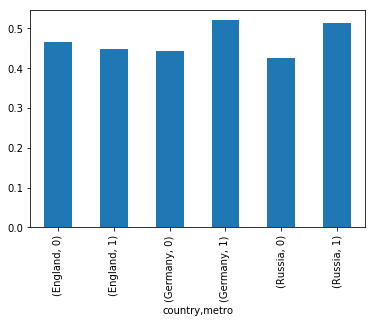

In [7]:
country_metro_grouping['mapUsed'].plot.bar()

1 signifies that it is a metro

Let's visualize the data based on the rating of the drivers

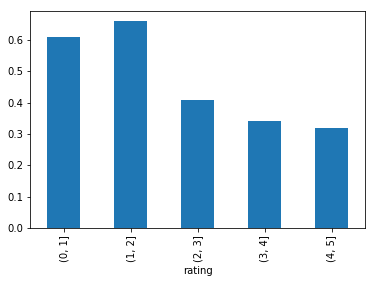

In [8]:
group_by_age = pd.cut(route_df["rating"], np.arange(0, 6, 1))
rating_grouping = route_df.groupby(group_by_age).mean()
rating_grouping['mapUsed'].plot.bar()

Most of the drivers are between the range of 1-2

Let's check for missing values by doing a count on each of the columns

In [9]:
route_df.count()

uid          500
name         500
metro        500
country      500
rating       500
startTime    500
endTime      500
oldRoute     500
newRoute     500
mapUsed      500
dtype: int64

There are no missing values. However if there are missing values we can deal with them in the following way:

1. If the column (col1) from which the values are missing is an important factor, we need to drop the rows containing those values.
```python
 route_df["col1"] = route_df["col1"].fillna("NA") #first fill the columns with value NA
 route_df = route_df.dropna() #drop the rows with missing values
```

2. If the column(col2,col3) is not an important factor, we can drop the column
```python
route_df = route_df.drop(['col2','col3'], axis=1) #drop the columns
```


Now for the preprocessing

In [10]:
def preprocess_route_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.country = le.fit_transform(processed_df.country)
    processed_df.oldRoute = le.fit_transform(processed_df.oldRoute)
    processed_df.newRoute = le.fit_transform(processed_df.newRoute)
    processed_df = processed_df.drop(['name','uid'],axis=1)
    return processed_df

What we are basically doing here is processing the data to produce numeric labels for the string data

Let's look at the data again

In [11]:
processed_df = preprocess_route_df(route_df)
processed_df

,metro,country,rating,startTime,endTime,oldRoute,newRoute,mapUsed
0,1,0,2.541688,17.3,19.3,0,0,1
1,0,2,1.858011,15.0,17.0,5,11,1
2,1,1,0.006557,17.0,19.0,4,10,0
3,1,0,3.832214,17.3,19.3,0,0,1
4,0,0,3.400957,16.0,17.3,2,6,0
5,0,2,3.913199,15.0,17.0,5,1,0
6,1,1,1.961354,17.0,19.0,4,10,0
7,1,1,4.488997,17.0,19.0,4,9,1
8,1,2,1.439535,14.3,17.0,1,2,1
9,0,1,2.305975,16.3,18.0,3,8,0


*X* contains all the values besides whether the map was used or not and *y* contains the answer 

In [12]:
X = processed_df.drop(['mapUsed'], axis=1).values
y = processed_df['mapUsed'].values

In [13]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

decision tree

In [14]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [15]:
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)

0.98999999999999999

In [16]:
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [17]:
test_classifier(clf_dt)

Accuracy: 0.9820 (+/- 0.01)


In [18]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.9935 (+/- 0.01)


In [19]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Accuracy: 0.9825 (+/- 0.01)


In [20]:
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)

Accuracy: 0.9895 (+/- 0.01)


neural Network

In [21]:
#tf_clf_dnn = skflow.TensorFlowDNNClassifier(hidden_units=[20, 40, 20], n_classes=2, batch_size=256, steps=1000, learning_rate=0.05)
feature_columns = [tf.contrib.layers.real_valued_column("")]
tf_clf_dnn = skflow.DNNClassifier(feature_columns=feature_columns, hidden_units=[20, 40, 20], n_classes=2, model_dir="/tmp")
#tf_clf_dnn.evaluate(batch_size=256, steps=1000)
tf_clf_dnn.fit(X_train, y_train, steps=1000)
accuracy_score = tf_clf_dnn.evaluate(X_test, y_test,steps=1000)["accuracy"]
print("\nTest Accuracy: {0:f}\n".format(accuracy_score))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_task_id': 0, '_save_summary_steps': 100, '_is_chief': True, '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_save_checkpoints_secs': 600, '_environment': 'local', '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002023EAE70B8>, '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_task_type': None, '_model_dir': None, '_keep_checkpoint_max': 5, '_evaluation_master': ''}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by mov

C:\Users\Saumya Suvarna\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp\model.ckpt.
INFO:tensorflow:loss = 0.912484, step = 1
INFO:tensorflow:global_step/sec: 82.549
INFO:tensorflow:loss = 0.505164, step = 101 (1.219 sec)
INFO:tensorflow:global_step/sec: 130.634
INFO:tensorflow:loss = 0.281694, step = 201 (0.764 sec)
INFO:tensorflow:global_step/sec: 119.969
INFO:tensorflow:loss = 0.121146, step = 301 (0.835 sec)
INFO:tensorflow:global_step/sec: 137.596
INFO:tensorflow:loss = 0.0692203, step = 401 (0.725 sec)
INFO:tensorflow:global_step/sec: 137.418
INFO:tensorflow:loss = 0.0492737, step = 501 (0.722 sec)
INFO:tensorflow:global_step/sec: 153